In [1]:
import math
import numpy as np

import drawsvg as draw
from drawsvg import Drawing
from hyperbolic import euclid
from hyperbolic.poincare import *
from hyperbolic.poincare.util import (
    radial_euclid_to_poincare, triangle_side_for_angles,
)
import hyperbolic.tiles as htiles

In [2]:
# Control the orientation that tiles are placed together
class TileLayoutIsosceles(htiles.TileLayout):
    def calc_gen_index(self, code):
        ''' Controls which type of tile to place '''
        return 0
    def calc_tile_touch_side(self, code, gen_index):
        ''' Controls tile orientation '''
        try:
            side, colors = code
            return 2 - side
        except TypeError:
            return 0
    def calc_side_codes(self, code, gen_index, touch_side, default_codes):
        ''' Controls tile side codes '''
        try:
            side, colors = code
            # 0=red, 1=orange, 2=yellow, 3=lime, 4=green, 5=blue, 6=pink
            if side != 1:
                if side == 0: shift = -1
                elif side == 2: shift = 1
                else: shift = 0
                nc = len(colors)
                new_colors = [colors[(i+shift)%nc] for i in range(nc)]
            else:
                new_colors = [colors[0], colors[1], colors[6], colors[4],
                    colors[3], colors[5], colors[2]]
        except TypeError:
            nc = q1
            new_colors = [(i+code)%nc for i in range(nc)]
        return [(side, new_colors) for side in range(3)]

In [3]:
q1 = 7  # Number of polygons around some points
q2 = 6  # Number of polygons around other points
depth = 10  # How far from the center to draw tiles

# Calculate isosceles triangle
assert q2 > 4 and q2 % 2 == 0, 'q2 must be even and at least 6'
phi1, phi2 = math.pi*2/q1, math.pi*2/q2
# Side lengths
s0 = triangle_side_for_angles(phi1, phi2, phi2)
s1 = triangle_side_for_angles(phi2, phi2, phi1)
s2 = s0
pt0 = Point.from_h_polar(0,0)
pt1 = Point.from_h_polar(s0,0)
pt2 = Point.from_h_polar(s2,-phi1)
# Circumcircle
circumcirc = euclid.Circle.from_points(*pt0, *pt1, *pt2)
r = radial_euclid_to_poincare(circumcirc.r)
pt_center = Point.from_euclid(circumcirc.cx, circumcirc.cy)
# Translate triangle to center
trans_center = Transform.shift_origin(pt_center, pt0)
ptc0, ptc1, ptc2 = trans_center(pt0, pt1, pt2)
center_points = (ptc0, ptc1, ptc2)
tile = htiles.Tile(center_points)

In [4]:
# Calculate weave width
# For right triangle: tan(A) = tanh(opp) / sinh(adj)
# => opp = atanh(tan(A) * sinh(adj))
r_insc = math.atanh(math.tan(phi2/2) * math.sinh(s1/2))  # Inscribed circle radius
h = math.atanh(math.tan(phi2) * math.sinh(s1/2))  # Triangle height
center_diff = r - (h - r_insc)

t_gen = htiles.TileGen.from_center_tile(tile)

decorator_late = htiles.TileDecoratorLateInit()

t_layout = TileLayoutIsosceles()
t_layout.add_generator(t_gen, (0,)*4, decorator_late)
start_tile = t_layout.start_tile(code=2,rotate_deg=0,center_corner=False)

tiles = t_layout.tile_plane(start_tile, depth=depth)

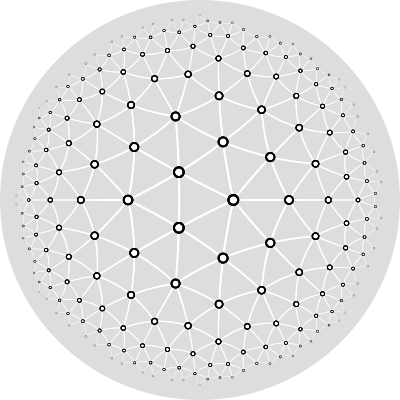

In [5]:
def draw_tiles(drawing, tiles):
    for tile in tiles:
        tile.decorator = None
        d.draw(tile, hwidth=0.02, fill='white')
    for tile in tiles:
        d.draw(tile, draw_verts=True, hradius=0.05, hwidth=0.02,
                     fill='black', opacity=0.6)
        
d = draw.Drawing(2, 2, origin='center')
d.draw(euclid.Circle(0, 0, 1), fill='#ddd')
draw_tiles(d, tiles)

d.set_render_size(w=400)
d.save_svg('images/isosceles-{}-{}.svg'.format(q1, q2))
d

In [6]:
# Draw a fancy weave pattern on each tile
class TileDecoratorWeaveColor(htiles.TileDecorator):
    color_map = ['red', 'orange', 'yellow', 'lime', 'green', 'blue', 'pink', 'gray']
    def __init__(self, width, inset, draw_extra,
                 base_tile, tile3, tile6, tile8_if_backside=None):
        tile8, backside = tile8_if_backside, tile8_if_backside is not None
        self.backside = backside
        self.trans = base_tile.trans.inverted()
        trans3 = Transform.merge(self.trans, tile3.trans)
        trans6 = Transform.merge(self.trans, tile6.trans)
        p1, p2 = trans3((0,0), (0,-0.5))
        p3, p4 = trans3(p1, p2)
        p5, p6 = trans6(p1, p2)
        p7, p8 = trans6(p3, p4)
        if backside:
            p_mirror1, p_mirror2 = base_tile.vertices[0], tile8.vertices[0]
            trans_mirror = Transform.mirror(p_mirror1, p_mirror2)
            p2, p1, p4, p3, p6, p5, p8, p7 = trans_mirror(p1, p2, p3, p4, p5, p6, p7, p8)
        line_main = Line.from_points(*p1, *p2, segment=False)
        line_cover1 = Line.from_points(*p3, *p4, segment=False)
        line_cover2 = Line.from_points(*p5, *p6, segment=False)
        line_extra2 = Line.from_points(*p7, *p8, segment=False)
        line_main1 = line_main.make_offset(width/2)
        line_main2 = line_main.make_offset(-width/2)
        line_main2.reverse()
        line_extra1 = line_cover2.make_offset(width/2)
        line_cover1 = line_cover1.make_offset(-width/2)
        line_cover2 = line_cover2.make_offset(-width/2)
        line_extra2 = line_extra2.make_offset(-width/2)
        if backside:
            edges = (line_cover2, line_main2, line_cover1, line_main1)
        else:
            edges = (line_cover1, line_main2, line_cover2, line_main1)
        poly = Polygon.from_edges(edges, join=True)
        poly = poly.offset_polygon(-inset)
        self.poly_points = poly.make_restore_points()
        if draw_extra:
            if backside:
                edges2 = (line_main2, line_extra1, line_extra2)
            else:
                edges2 = (line_main2, line_extra2, line_extra1)
            poly2 = Polygon.from_edges(edges2, join=True)
            poly2 = poly2.offset_polygon(-inset)
            self.poly_points2 = poly2.make_restore_points()
        else:
            self.poly_points2 = None
    def to_drawables(self, tile=None, **kwargs):
        trans = self.trans
        if tile is not None:
            trans = Transform.merge(trans, tile.trans)
            color_i = tile.sides[0].code[1][0]
        else:
            color_i = -1
        color = self.color_map[color_i]
        poly_points = trans.apply_to_list(self.poly_points)
        poly = Polygon.from_restore_points(poly_points)
        if self.poly_points2 is not None:
            poly_points2 = trans.apply_to_list(self.poly_points2)
            poly2 = Polygon.from_restore_points(poly_points2)
        else:
            poly2 = None
        ds = []
        ds.extend(poly.to_drawables(fill=color, **kwargs))
        if poly2 is not None:
            ds.extend(poly2.to_drawables(fill=color, **kwargs))
        return ds

In [7]:
# Find weave width and center
pa0 = tiles[49].vertices[0]
pa1 = tiles[0].vertices[0]
pa2 = tiles[38].vertices[0]
pb0 = tiles[8].vertices[0]
pb1 = tiles[5].vertices[0]
pb2 = tiles[127].vertices[0]
hyp1 = Hypercycle.from_points(*pa0, *pa1, *pa2, segment=False)
hyp2 = Hypercycle.from_points(*pb0, *pb1, *pb2, segment=False)
pm1 = hyp1.midpoint_euclid()
pm2 = hyp2.midpoint_euclid()
weave_width_wide = pm1.distance_to(pm2)
pmm = Transform.translation(pm2, pm1).apply_to_point(Point.from_h_polar(weave_width_wide/2,0))
# Find thin width
pc0, pc1 = tiles[0].vertices[1:3]
line3 = Line.from_points(*pc0, *pc1, segment=False)
pm3 = line3.midpoint_euclid()
weave_width_thin = weave_width_wide - 2*pm3.distance_to(pm2)

In [8]:
# Translate all tiles to center
translate = Transform.shift_origin(pmm, pm1)
tiles = [tile.make_transformed(translate) for tile in tiles]
base_tiles = tiles
base_tile = tiles[0]

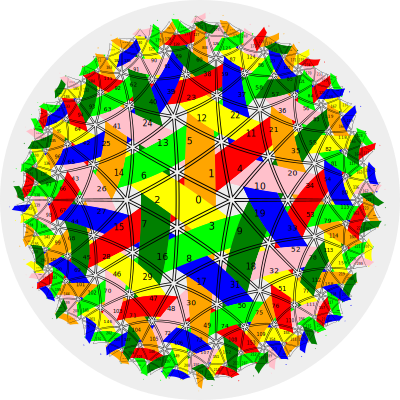

In [9]:
d = draw.Drawing(2, 2, origin='center')
d.draw(euclid.Circle(0, 0, 1), fill='#eee')

decorator = TileDecoratorWeaveColor(
        weave_width_thin*0.7, 0, True,
        tiles[0], tiles[3], tiles[6])

for tile in tiles:
    tile.decorator = decorator
    d.draw(tile)
decorate_outline = htiles.TileDecoratorOffset(0.01)
for tile in tiles:
    tile.decorator = decorate_outline
    d.draw(tile, hwidth=(0, 0.01))
decorate_nums = htiles.TileDecoratorNumbered(size=0.1)
for tile in tiles:
    tile.decorator = decorate_nums
    d.draw(tile)

d.set_render_size(w=400)
d.save_svg('images/isosceles_weave_outline.svg')
d